In [1]:
from utils import *
from evaluate import evaluate

Using TensorFlow backend.


In [2]:
questions = pd.read_csv('./question_train_word.csv')
questions_topics = questions.topics.apply(lambda s: s.split(','))
questions_titles = questions.title.astype('U').apply(lambda s: s.split(','))

In [3]:
# %time questions_set = pd.read_csv('./question_train_set.txt', sep='\t', names=['id', 'c', 'w', 'd_c', 'd_w'])
# %time questions_topics_set = pd.read_csv('./question_topic_train_set.txt', sep='\t', names=['q_id', 't_ids'])

CPU times: user 3.45 s, sys: 386 ms, total: 3.84 s
Wall time: 4.36 s


In [7]:
# questions_topics = questions_set.w.astype('U').apply(lambda s: s.split(','))
# questions_titles = questions_topics_set.t_ids.astype('U').apply(lambda s: s.split(','))

In [3]:
print(questions_topics[0])
print(questions_titles[0])

['7739004195693774975', '3738968195649774859']
['w305', 'w13549', 'w22752', 'w11', 'w7225', 'w2565', 'w1106', 'w16', 'w31389', 'w6', 'w1019', 'w69288', 'w111', 'w3332', 'w109', 'w11', 'w25', 'w1110', 'w111']


In [3]:
from gensim.models import KeyedVectors
%time word_vec = KeyedVectors.load_word2vec_format('word_embedding.txt')

CPU times: user 1min 35s, sys: 2.34 s, total: 1min 37s
Wall time: 1min 45s


In [4]:
questions_titles_len = pd.Series([len(t) for t in questions_titles])

In [5]:
max(questions_titles_len)

187

In [6]:
%matplotlib inline

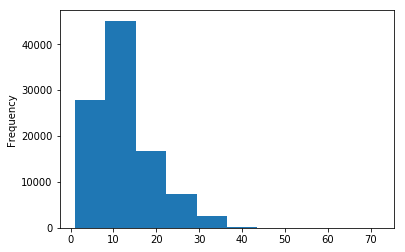

In [7]:
questions_titles_len[:100000].plot.hist()

In [4]:
word_keys = list(set([w for t in questions_titles for w in t]))
print(len(word_keys))
word_keys_dict = {v: i for i, v in enumerate(word_keys)}

324960


In [5]:
from numpy.random import normal

def create_emb():
    n_fact = word_vec.vector_size
    emb = np.zeros((len(word_keys), n_fact))

    for i in range(0,len(emb)):
        word = word_keys[i]
        if word and word in word_vec:
            emb[i] = word_vec[word]
        else:
            # If we can't find the word in glove, randomly initialize
            emb[i] = normal(scale=0.6, size=(n_fact,))

    # This is our "rare word" id - we want to randomly initialize
    emb[-1] = normal(scale=0.6, size=(n_fact,))
    emb/=3
    return emb

In [6]:
emb = create_emb()

In [12]:
i = 50
w = word_keys[i]
print(w)
print(emb[i])
print(word_keys_dict[w])
if w and w in word_vec:
    print(word_vec[w])

w178227
[ 0.060332    0.00591433 -0.067409    0.01499167  0.01260167  0.03282867
 -0.00044767 -0.01746533  0.03909433  0.030068    0.05370766 -0.00919933
 -0.01167867 -0.02313167  0.02772533 -0.03005533 -0.04077533 -0.03626467
 -0.01963033 -0.025137   -0.066821   -0.02179267 -0.012803   -0.00491967
 -0.03292933 -0.07019     0.01393667 -0.02462267 -0.06691633 -0.00819167
 -0.049964   -0.016244    0.12303533 -0.003486   -0.089485   -0.03087567
  0.07041433 -0.00774833  0.035902    0.07375267 -0.034108    0.01138533
  0.02633667 -0.10702433 -0.06009233 -0.026187   -0.042457   -0.00581367
  0.044865    0.01926567 -0.058295    0.042506   -0.067906   -0.04257833
  0.060002    0.05366766  0.00961333 -0.02007933  0.02800467  0.03502933
  0.03267733  0.07308    -0.013555    0.02589     0.01514067  0.05228767
  0.02910833 -0.03413367 -0.080218   -0.049996    0.00430133 -0.025227
 -0.00999633 -0.001964   -0.044657    0.013493    0.00657033  0.06222167
 -0.074813   -0.055948   -0.047864    0.01675

In [7]:
questions_titles_format = [[word_keys_dict[t] for t in title] for title in questions_titles]
print(questions_titles_format[0])

[76288, 47169, 144191, 287247, 129210, 88772, 79842, 44351, 256221, 252221, 242224, 228944, 171759, 254536, 171061, 287247, 268879, 84994, 171759]


In [8]:
from sklearn.preprocessing import MultiLabelBinarizer
mb = MultiLabelBinarizer()
y = mb.fit_transform(questions_topics)

In [10]:
mb_sparse = MultiLabelBinarizer(sparse_output=True)
y_sparse = mb_sparse.fit_transform(questions_topics)

In [11]:
x_train = sequence.pad_sequences(questions_titles_format, maxlen=35)

def train_generator(size):
    for i in range(size):
        yield x_train[i], y_sparse[i].toarray()

In [14]:
sample_size = 10000
x_train_sample = sequence.pad_sequences(questions_titles_format[:sample_size], maxlen=35)
y_train_sample = y[:sample_size]

In [16]:
x_test_sample = sequence.pad_sequences(questions_titles_format[-100:], maxlen=35)
y_test_sample = y[-100:]

In [19]:
x_train_sample[0]

array([     0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
       106000,  78185,  27740,  96558, 315971, 294399,  90176,    730,
       298641, 315768, 153282,  95217,  89758,  58143, 289583,  96558,
        76318, 199841,  89758], dtype=int32)

In [9]:
embedding_dim = word_vec.vector_size
sequence_lenght = 35
num_filters = 100
dropout_prob = [0.5, 0.5]
# hidden_dims = 2000

model = Sequential ([
    Embedding(len(word_keys), embedding_dim, input_length=sequence_lenght, weights=[emb]),
    Dropout (dropout_prob[0]),
    Convolution1D(num_filters, 3, activation="relu"),
    MaxPooling1D(),
    Flatten(),
    Dropout (dropout_prob[1]),
#     Dense (hidden_dims, activation="relu"),
    Dense (1999, activation='sigmoid'),
    ])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

In [20]:
batch_size = 64
num_epochs = 3

history = model.fit(x_train_sample, y_train_sample,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    validation_data=(x_test_sample, y_test_sample))

Train on 10000 samples, validate on 100 samples
Epoch 1/3
10000/10000 [==============================] - 229s - loss: 18.7827 - categorical_accuracy: 0.0142 - val_loss: 14.4905 - val_categorical_accuracy: 0.0100

In [91]:
batch_size = 64
num_epochs = 3

history = model.fit(x_train_sample, y_train_sample,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    validation_data=(x_test_sample, y_test_sample))

Train on 10000 samples, validate on 100 samples
Epoch 1/3
10000/10000 [==============================] - 226s - loss: 0.0401 - acc: 0.9926 - categorical_accuracy: 0.0043 - top_k_categorical_accuracy: 0.0156 - val_loss: 0.0134 - val_acc: 0.9991 - val_categorical_accuracy: 0.0000e+00 - val_top_k_categorical_accuracy: 0.0000e+00

In [21]:
predict_train = model.predict(x_train_sample[:100])
predict_train.shape

(100, 1999)

In [93]:
np.array(predict_train[0]).argsort()[-5:][::-1]

array([ 609, 1443, 1041, 1322, 1331])

In [94]:
index = 3
print(questions_topics[index])
[mb.classes_[i] for i in np.array(predict_train[index]).argsort()[-5:][::-1]]

['-6758942141122113907', '3195914392210930723']


['-5932391056759866388',
 '3804601920633030746',
 '1127459907694805235',
 '8057405216243595195',
 '7327336430450495350']

In [22]:
from evaluate import evaluate
result = [[mb.classes_[a] for a in np.array(predict_train[i]).argsort()[-5:][::-1]] for i in range(100)]
evaluate(zip(result, questions_topics[:100]))

(0.061188138750681347, 0.1741239076623248, 0.09433962264150944, 20, 212)

In [23]:
predict_test = model.predict(x_test_sample)
print(predict_test.shape)
result = [[mb.classes_[a] for a in np.array(predict_test[i]).argsort()[-5:][::-1]] for i in range(100)]
evaluate(zip(result, questions_topics[-100:]))

(100, 1999)


(0.01596100525614803, 0.03838374440987187, 0.0273224043715847, 5, 183)

In [24]:
embedding_dim = word_vec.vector_size
sequence_lenght = 35
num_filters = 1024
dropout_prob = [0.5, 0.5]
# hidden_dims = 2000

model = Sequential ([
    Embedding(len(word_keys), embedding_dim, input_length=sequence_lenght, weights=[emb]),
    Dropout (dropout_prob[0]),
    Convolution1D(num_filters, 3, activation="relu"),
    MaxPooling1D(),
    Flatten(),
    Dropout (dropout_prob[1]),
#     Dense (hidden_dims, activation="relu"),
    Dense (1999, activation='sigmoid'),
    ])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

In [25]:
batch_size = 64
num_epochs = 1

history = model.fit(x_train_sample, y_train_sample,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    validation_data=(x_test_sample, y_test_sample))

Train on 10000 samples, validate on 100 samples
Epoch 1/1
10000/10000 [==============================] - 382s - loss: 18.5807 - categorical_accuracy: 0.0150 - val_loss: 14.3214 - val_categorical_accuracy: 0.0100

In [26]:
result = [[mb.classes_[a] for a in np.array(predict_train[i]).argsort()[-5:][::-1]] for i in range(100)]
evaluate(zip(result, questions_topics[:100]))

(0.061188138750681347, 0.1741239076623248, 0.09433962264150944, 20, 212)

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 35, 256)           83189760  
_________________________________________________________________
dropout_5 (Dropout)          (None, 35, 256)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 33, 1024)          787456    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 16, 1024)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16384)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1999)              32753615  
Total para

In [29]:
embedding_dim = word_vec.vector_size
sequence_lenght = 35
num_filters = 1024
dropout_prob = [0.5, 0.5]
# hidden_dims = 2000

model = Sequential ([
    Embedding(len(word_keys), embedding_dim, input_length=sequence_lenght, weights=[emb], trainable=False),
    Dropout (dropout_prob[0]),
    Convolution1D(num_filters, 3, activation="relu"),
    MaxPooling1D(),
    Flatten(),
    Dropout (dropout_prob[1]),
#     Dense (hidden_dims, activation="relu"),
    Dense (1999, activation='sigmoid'),
    ])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

In [30]:
batch_size = 64
num_epochs = 1

history = model.fit(x_train_sample, y_train_sample,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    validation_data=(x_test_sample, y_test_sample))

Train on 10000 samples, validate on 100 samples
Epoch 1/1
10000/10000 [==============================] - 163s - loss: 18.6610 - categorical_accuracy: 0.0121 - val_loss: 14.1218 - val_categorical_accuracy: 0.0100

In [32]:
batch_size = 64
num_epochs = 1

history = model.fit(x_train_sample, y_train_sample,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    validation_data=(x_test_sample, y_test_sample))

Train on 10000 samples, validate on 100 samples
Epoch 1/1
10000/10000 [==============================] - 168s - loss: 17.4271 - categorical_accuracy: 0.0168 - val_loss: 14.2922 - val_categorical_accuracy: 0.0000e+00

In [34]:
predict_train = model.predict(x_train_sample[:100])
result = [[mb.classes_[a] for a in np.array(predict_train[i]).argsort()[-5:][::-1]] for i in range(100)]
evaluate(zip(result, questions_topics[:100]))

(0.11542465811040258, 0.32417930003081014, 0.1792452830188679, 38, 212)

In [35]:
batch_size = 64
num_epochs = 1

history = model.fit(x_train_sample, y_train_sample,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    validation_data=(x_test_sample, y_test_sample))

Train on 10000 samples, validate on 100 samples
Epoch 1/1
10000/10000 [==============================] - 154s - loss: 15.6745 - categorical_accuracy: 0.0368 - val_loss: 14.2983 - val_categorical_accuracy: 0.0100

In [36]:
predict_train = model.predict(x_train_sample[:100])
result = [[mb.classes_[a] for a in np.array(predict_train[i]).argsort()[-5:][::-1]] for i in range(100)]
evaluate(zip(result, questions_topics[:100]))

(0.23321645988628073, 0.7027420952722551, 0.3490566037735849, 74, 212)

In [37]:
predict_test = model.predict(x_test_sample)
result = [[mb.classes_[a] for a in np.array(predict_test[i]).argsort()[-5:][::-1]] for i in range(100)]
evaluate(zip(result, questions_topics[-100:]))

(0.035025243152248614, 0.09755301178142974, 0.0546448087431694, 10, 183)

In [39]:
embedding_dim = word_vec.vector_size
sequence_lenght = 35
num_filters = 1024
dropout_prob = [0.5, 0.5]
# hidden_dims = 2000

model = Sequential ([
    Embedding(len(word_keys), embedding_dim, input_length=sequence_lenght, weights=[emb], trainable=False),
    Dropout (dropout_prob[0]),
    Convolution1D(num_filters, 3, activation="relu"),
    MaxPooling1D(3),
    Convolution1D(num_filters, 3, activation="relu"),
    MaxPooling1D(3),
    Flatten(),
    Dropout (dropout_prob[1]),
#     Dense (hidden_dims, activation="relu"),
    Dense (1999, activation='sigmoid'),
    ])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

In [40]:
batch_size = 64
num_epochs = 1

history = model.fit(x_train_sample, y_train_sample,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    validation_data=(x_test_sample, y_test_sample))

Train on 10000 samples, validate on 100 samples
Epoch 1/1
10000/10000 [==============================] - 173s - loss: 18.7364 - categorical_accuracy: 0.0096 - val_loss: 14.6368 - val_categorical_accuracy: 0.0000e+00

In [41]:
predict_test = model.predict(x_test_sample)
result = [[mb.classes_[a] for a in np.array(predict_test[i]).argsort()[-5:][::-1]] for i in range(100)]
evaluate(zip(result, questions_topics[-100:]))

(0.011788415430740789, 0.025589162939914582, 0.02185792349726776, 4, 183)

In [42]:
predict_train = model.predict(x_train_sample[:100])
result = [[mb.classes_[a] for a in np.array(predict_train[i]).argsort()[-5:][::-1]] for i in range(100)]
evaluate(zip(result, questions_topics[:100]))

(0.015915961213388546, 0.04894760241213957, 0.02358490566037736, 5, 212)

In [9]:
def try_predict(model, batch_size, num_epochs):
    history = model.fit(x_train_sample, y_train_sample,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    validation_data=(x_test_sample, y_test_sample))
    
    predict_train = model.predict(x_train_sample[:100])
    result = [[mb.classes_[a] for a in np.array(predict_train[i]).argsort()[-5:][::-1]] for i in range(100)]
    print(evaluate(zip(result, questions_topics[:100])))

    predict_test = model.predict(x_test_sample)
    result = [[mb.classes_[a] for a in np.array(predict_test[i]).argsort()[-5:][::-1]] for i in range(100)]
    print(evaluate(zip(result, questions_topics[-100:])))

In [44]:
try_predict(model, 64, 1)

Train on 10000 samples, validate on 100 samples
Epoch 1/1
10000/10000 [==============================] - 151s - loss: 18.1802 - categorical_accuracy: 0.0012 - val_loss: 14.3430 - val_categorical_accuracy: 0.0000e+00

In [45]:
try_predict(model, 64, 1)

Train on 10000 samples, validate on 100 samples
Epoch 1/1
10000/10000 [==============================] - 154s - loss: 17.7419 - categorical_accuracy: 0.0045 - val_loss: 14.5689 - val_categorical_accuracy: 0.0100

In [46]:
try_predict(model, 64, 1)

Train on 10000 samples, validate on 100 samples
Epoch 1/1
10000/10000 [==============================] - 148s - loss: 17.4116 - categorical_accuracy: 0.0070 - val_loss: 14.9334 - val_categorical_accuracy: 0.0100

## Three Convolution: 1, 2, 3

In [11]:
filter_sizes = [1,2,3]
num_filters = 1024
sequence_lenght = 35

graph_in = Input ((sequence_lenght, 256))
convs = [ ] 
for fsz in filter_sizes: 
    x = Convolution1D(num_filters, fsz, activation="relu")(graph_in)
    x = MaxPooling1D()(x) 
    x = Flatten()(x) 
    convs.append(x)
graph = Concatenate()(convs)
graph = Model(graph_in, graph)

In [12]:
embedding_dim = word_vec.vector_size
sequence_lenght = 35
dropout_prob = [0.5, 0.5]


model = Sequential ([
    Embedding(len(word_keys), embedding_dim, input_length=sequence_lenght, weights=[emb], trainable=False),
    Dropout (dropout_prob[0]),
    graph,
    Dropout (dropout_prob[1]),
#     Dense (hidden_dims, activation="relu"),
    Dense (1999, activation='sigmoid'),
    ])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

In [17]:
try_predict(model, 64, 1)

Train on 10000 samples, validate on 100 samples
Epoch 1/1
 3008/10000 [========>.....................] - ETA: 371s - loss: 19.0868 - categorical_accuracy: 0.0133     

KeyboardInterrupt: 

In [49]:
try_predict(model, 64, 1)

Train on 10000 samples, validate on 100 samples
Epoch 1/1
10000/10000 [==============================] - 445s - loss: 18.5872 - categorical_accuracy: 0.0129 - val_loss: 14.0458 - val_categorical_accuracy: 0.0100

In [50]:
try_predict(model, 64, 1)

Train on 10000 samples, validate on 100 samples
Epoch 1/1
10000/10000 [==============================] - 466s - loss: 16.7716 - categorical_accuracy: 0.0264 - val_loss: 14.1388 - val_categorical_accuracy: 0.0000e+00

In [51]:
try_predict(model, 64, 1)

Train on 10000 samples, validate on 100 samples
Epoch 1/1
10000/10000 [==============================] - 429s - loss: 14.1111 - categorical_accuracy: 0.0755 - val_loss: 14.2382 - val_categorical_accuracy: 0.0200

In [52]:
try_predict(model, 64, 1)

Train on 10000 samples, validate on 100 samples
Epoch 1/1
10000/10000 [==============================] - 443s - loss: 10.9559 - categorical_accuracy: 0.1739 - val_loss: 14.2843 - val_categorical_accuracy: 0.0200

In [53]:
model.save_weights('model_v2.h5')

In [11]:
embedding_dim = word_vec.vector_size
sequence_lenght = 35
num_filters = 1024
dropout_prob = [0.5, 0.5]
filter_size = 1
# hidden_dims = 2000

model = Sequential ([
    Embedding(len(word_keys), embedding_dim, input_length=sequence_lenght, weights=[emb], trainable=False),
    Dropout (dropout_prob[0]),
    Convolution1D(num_filters, filter_size, activation="relu"),
    MaxPooling1D(3),
    Flatten(),
    Dropout (dropout_prob[1]),
#     Dense (hidden_dims, activation="relu"),
    Dense (1999, activation='sigmoid'),
    ])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

In [18]:
try_predict(model, 64, 1)

Train on 10000 samples, validate on 100 samples
Epoch 1/1
10000/10000 [==============================] - 104s - loss: 18.6962 - categorical_accuracy: 0.0146 - val_loss: 14.3487 - val_categorical_accuracy: 0.0100

In [19]:
try_predict(model, 64, 1)

Train on 10000 samples, validate on 100 samples
Epoch 1/1
10000/10000 [==============================] - 106s - loss: 17.7588 - categorical_accuracy: 0.0151 - val_loss: 14.3708 - val_categorical_accuracy: 0.0100

In [ ]:
try_predict(model, 64, 1)

Train on 10000 samples, validate on 100 samples
Epoch 1/1
 1664/10000 [===>..........................] - ETA: 89s - loss: 16.7577 - categorical_accuracy: 0.0180 